# * Do this, only if you are using Google Colab. *

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json /root/.kaggle/

In [ ]:
import os
for filename in os.listdir('/content'):
    print(filename)

.config
kaggle.json
sample_data


In [ ]:
# Set the permissions for the kaggle.json file to make it readable only by the owner
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c godaddy-microbusiness-density-forecasting

  0% 0.00/1.83M [00:00<?, ?B/s]
100% 1.83M/1.83M [00:00<00:00, 155MB/s]


In [ ]:
!unzip godaddy-microbusiness-density-forecasting.zip

Archive:  godaddy-microbusiness-density-forecasting.zip
  inflating: census_starter.csv      
  inflating: revealed_test.csv       
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# 1. Importing Libraries:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import pickle

from itertools import combinations
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

# 2. Importing data:

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
census = pd.read_csv('/content/census_starter.csv')
sample = pd.read_csv('/content/sample_submission.csv')

# 3. Checking data:

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB


In [ ]:
# Checking for null values in the 'train' DataFrame
print("Null values in train dataset:")
print(train.isnull().sum())

# Checking for null values in the 'test' DataFrame
print("\nNull values in test dataset:")
print(test.isnull().sum())

# Checking for null values in the 'census' DataFrame
print("\nNull values in census dataset:")
print(census.isnull().sum())

# Checking for null values in the 'sample' DataFrame
print("\nNull values in sample dataset:")
print(sample.isnull().sum())

Null values in train dataset:
row_id                   0
cfips                    0
county                   0
state                    0
first_day_of_month       0
microbusiness_density    0
active                   0
dtype: int64

Null values in test dataset:
row_id                0
cfips                 0
first_day_of_month    0
dtype: int64

Null values in census dataset:
pct_bb_2017              0
pct_bb_2018              0
pct_bb_2019              0
pct_bb_2020              1
pct_bb_2021              1
cfips                    0
pct_college_2017         0
pct_college_2018         0
pct_college_2019         0
pct_college_2020         1
pct_college_2021         1
pct_foreign_born_2017    0
pct_foreign_born_2018    0
pct_foreign_born_2019    0
pct_foreign_born_2020    1
pct_foreign_born_2021    1
pct_it_workers_2017      0
pct_it_workers_2018      1
pct_it_workers_2019      0
pct_it_workers_2020      1
pct_it_workers_2021      1
median_hh_inc_2017       0
median_hh_inc_2018       1


Looks like census data contains some missing values. Let's fill them up using the mean values.

In [ ]:
# Calculate the mean values for each column in the census DataFrame
mean_values = census.mean()

# Fill null values with mean values
census_filled = census.fillna(mean_values)

# Verify that null values are filled
print(census_filled.isnull().sum())

pct_bb_2017              0
pct_bb_2018              0
pct_bb_2019              0
pct_bb_2020              0
pct_bb_2021              0
cfips                    0
pct_college_2017         0
pct_college_2018         0
pct_college_2019         0
pct_college_2020         0
pct_college_2021         0
pct_foreign_born_2017    0
pct_foreign_born_2018    0
pct_foreign_born_2019    0
pct_foreign_born_2020    0
pct_foreign_born_2021    0
pct_it_workers_2017      0
pct_it_workers_2018      0
pct_it_workers_2019      0
pct_it_workers_2020      0
pct_it_workers_2021      0
median_hh_inc_2017       0
median_hh_inc_2018       0
median_hh_inc_2019       0
median_hh_inc_2020       0
median_hh_inc_2021       0
dtype: int64


Without wasting time in data visualization, let's get started with the Time Series Analysis, as this project solely focuses on forecasting.

# 4. Time Series:

In [ ]:
data = train[['first_day_of_month', 'microbusiness_density']].copy()
data['Date'] = pd.to_datetime(data['first_day_of_month'])
data.set_index('Date', inplace=True)
data.drop(columns='first_day_of_month', inplace=True)

data.head()

microbusiness_density
Date                             
2019-08-01                   3.01
2019-09-01                   2.88
2019-10-01                   3.06
2019-11-01                   2.99
2019-12-01                   2.99

In [ ]:
data = data.groupby(data.index).mean()
data.head()

microbusiness_density
Date                             
2019-08-01                   3.75
2019-09-01                   3.70
2019-10-01                   3.78
2019-11-01                   3.72
2019-12-01                   3.72

In [ ]:
from pandas.core import window
def test_stationarity(timeseries):
  #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',
                                             '#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
def timeseries_plot(y, lags=None, figsize=(12, 7), style='bmh'):
    y = pd.Series(y) if not isinstance(y, pd.Series) else y

    with plt.style.context(style):
        fig, axes = plt.subplots(2, 2, figsize=figsize)

        y.plot(ax=axes[0, 0])
        p_value = smt.adfuller(y)[1]
        axes[0, 0].set_title(f'Time Series Analysis Plots\nDickey-Fuller: p={p_value:.5f}')

        smt.graphics.plot_acf(y, lags=lags, ax=axes[1, 0])
        smt.graphics.plot_pacf(y, lags=lags, ax=axes[1, 1])

        plt.tight_layout()

<Axes: xlabel='Date'>

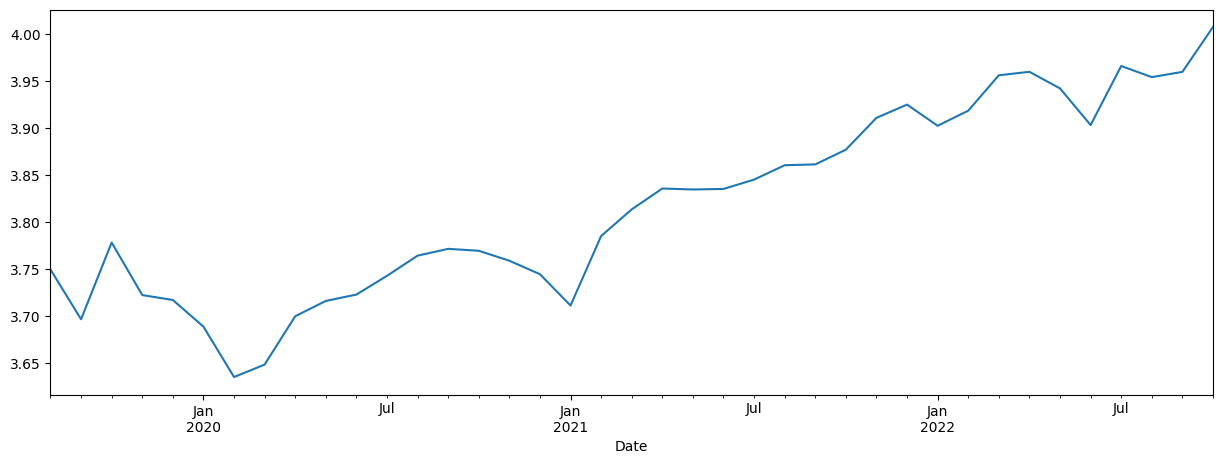

In [ ]:
plt.figure(figsize=(15,5))
data['microbusiness_density'].plot()

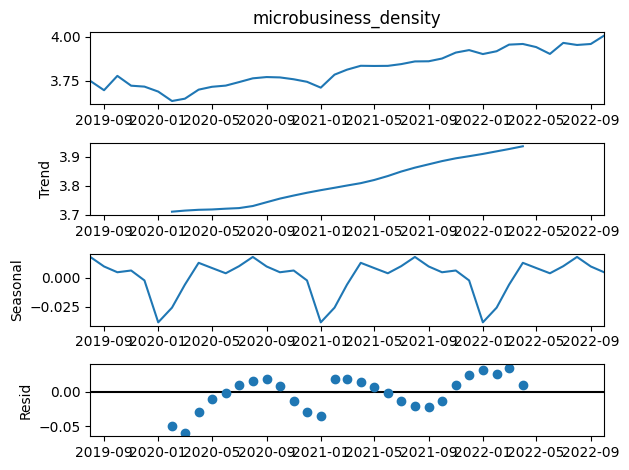

In [ ]:
result = sm.tsa.seasonal_decompose(data['microbusiness_density'], period=12,
                                   model='additive')
result.plot()
plt.show()

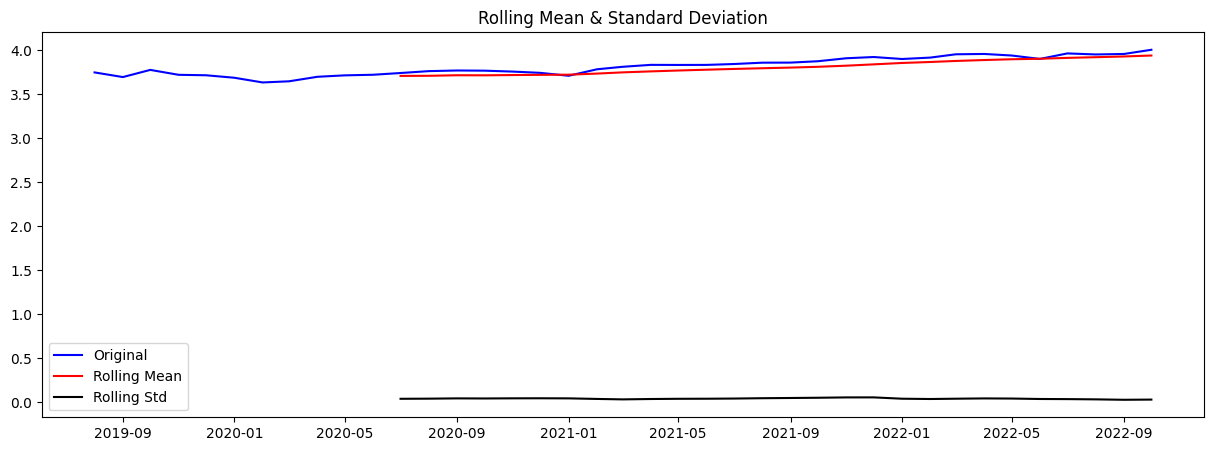

Results of Dickey-Fuller Test:
Test Statistic                -0.18
p-value                        0.94
#Lags Used                     0.00
Number of Observations Used   38.00
Critical Value (1%)           -3.62
Critical Value (5%)           -2.94
Critical Value (10%)          -2.61
dtype: float64


In [ ]:
test_stationarity(data['microbusiness_density'])

Since "Test Statistic" value (-0.18) > "Critical Value (5%)" (-2.94), we cannot reject the "Null Hypothesis".

Hence, the time series is not stationary.

In order to eliminate the trend, seasonality and make the series stationary, we will use **"differencing"**: subtracting the previous value from it's next value.

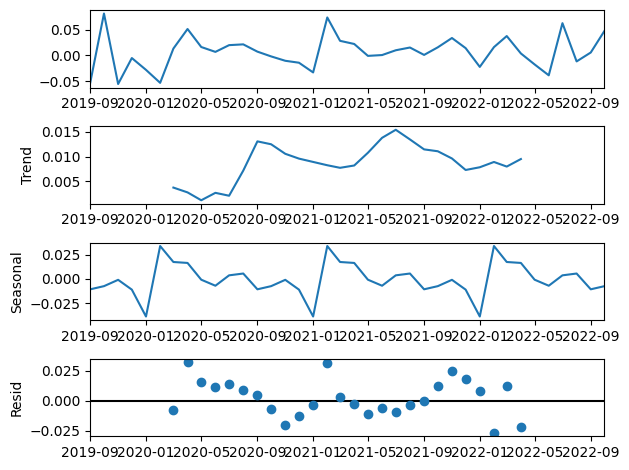

In [ ]:
data_diff = data.diff()
data_diff = data_diff.dropna()

dec = sm.tsa.seasonal_decompose(data_diff, period = 12).plot()
plt.show()

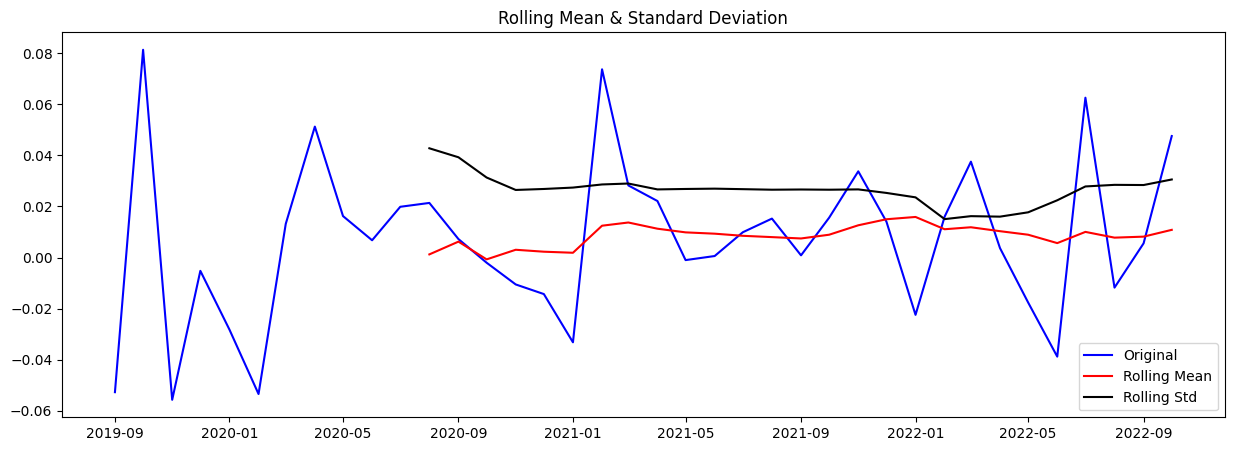

Results of Dickey-Fuller Test:
Test Statistic                -4.59
p-value                        0.00
#Lags Used                     1.00
Number of Observations Used   36.00
Critical Value (1%)           -3.63
Critical Value (5%)           -2.95
Critical Value (10%)          -2.61
dtype: float64


In [ ]:
test_stationarity(data_diff)



*   Rolling Mean is close to 0,
*   Rolling Std Dev is also close to 0,
*   Test Statistic (-4.59) < Critical Value (5%): -2.95
*   p-value (0.00) < 0.05

Now, we cannot reject the "Null Hypothesis", as the time series is stationary.



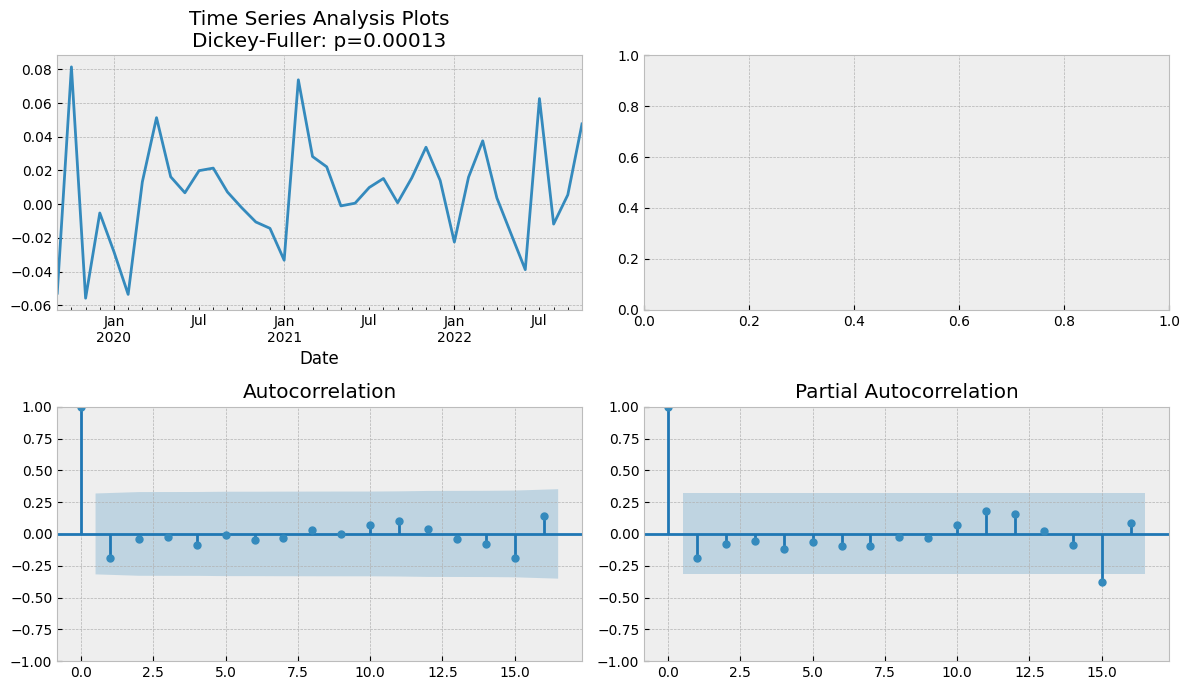

In [ ]:
timeseries_plot(data_diff['microbusiness_density'])

### 4.a) ARIMA Model:

In [ ]:
model = ARIMA(data['microbusiness_density'], order = (0,0,0))
model_fit = model.fit()
print(model_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:     microbusiness_density   No. Observations:                   39
Model:                             ARIMA   Log Likelihood                  34.482
Date:                   Fri, 11 Aug 2023   AIC                            -64.964
Time:                           05:10:17   BIC                            -61.637
Sample:                       08-01-2019   HQIC                           -63.770
                            - 10-01-2022                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8177      0.016    236.742      0.000       3.786       3.849
sigma2         0.0100      0.004      2.835      0.005       0.003       0.017
Ljung-Box (L1) (Q):         

### 4.b) ARMA Model:

In [ ]:
model = ARIMA(data['microbusiness_density'],order = (0,0,0))
model_fit = model.fit()
print(model_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:     microbusiness_density   No. Observations:                   39
Model:                             ARIMA   Log Likelihood                  34.482
Date:                   Fri, 11 Aug 2023   AIC                            -64.964
Time:                           05:16:46   BIC                            -61.637
Sample:                       08-01-2019   HQIC                           -63.770
                            - 10-01-2022                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8177      0.016    236.742      0.000       3.786       3.849
sigma2         0.0100      0.004      2.835      0.005       0.003       0.017
Ljung-Box (L1) (Q):         

**ARIMA Model:**

ARIMA model is a combination of 3 models :

* AR (p) : Auto Regressive
* I (d) : Integrated
* MA (q) : Moving Average

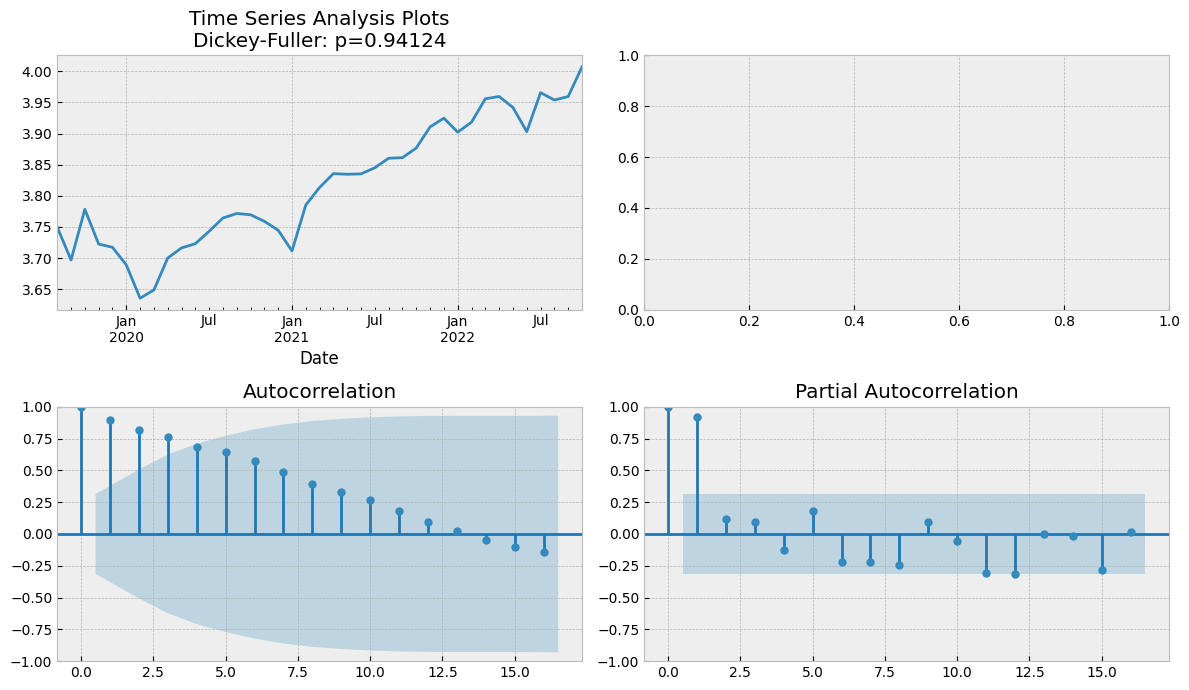

In [ ]:
timeseries_plot(data['microbusiness_density'])

In [ ]:
model = ARIMA(data['microbusiness_density'],order = (0,1,0))
model_fit = model.fit()
print(model_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:     microbusiness_density   No. Observations:                   39
Model:                    ARIMA(0, 1, 0)   Log Likelihood                  76.040
Date:                   Fri, 11 Aug 2023   AIC                           -150.080
Time:                           05:20:13   BIC                           -148.442
Sample:                       08-01-2019   HQIC                          -149.497
                            - 10-01-2022                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0011      0.000      4.494      0.000       0.001       0.002
Ljung-Box (L1) (Q):                   1.45   Jarque-Bera (JB):                 0.13
Prob(Q):               

**SARIMA Model**

Seasonal Auto Regressive Integrated Moving Average:
* Extension of the ARIMA model that can handle the seasonal effects of the data.
* It has kind of 2 orders (p,d,q) x (P,D,Q,M).

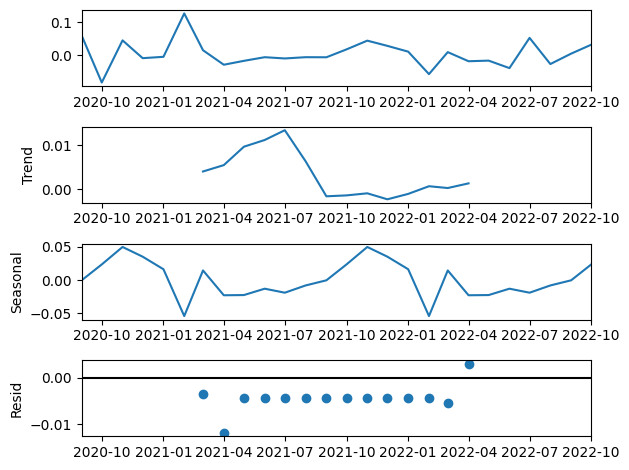

In [ ]:
data_diff_seas = data_diff.diff(12)
data_diff_seas = data_diff_seas.dropna()
dec = sm.tsa.seasonal_decompose(data_diff_seas,period = 12)
dec.plot()
plt.show()

Our data is in monthly format and the seasonal period is of 1 year.
Hence, we difference the already differenced data by a periodicity, M, value of 12.

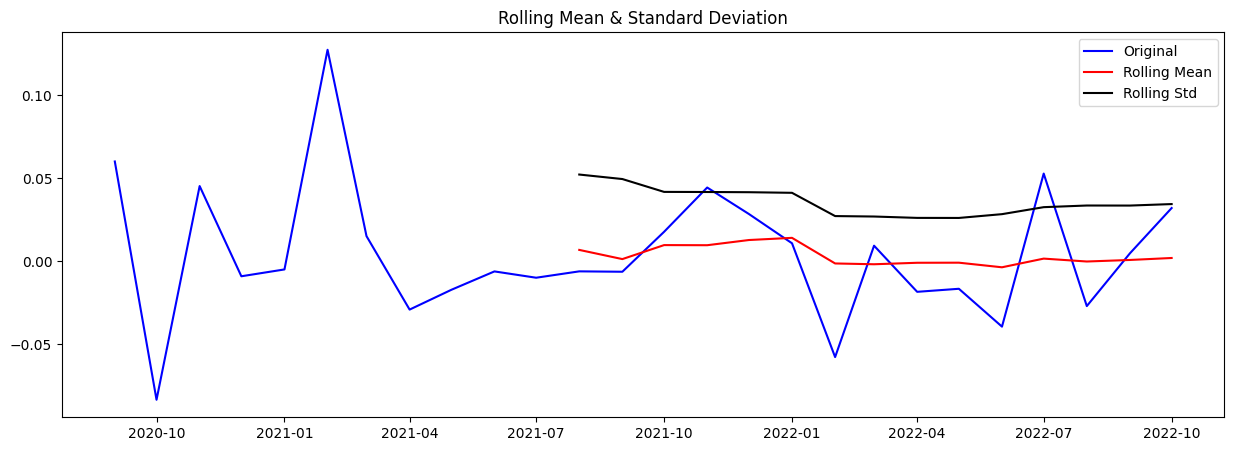

Results of Dickey-Fuller Test:
Test Statistic                -6.18
p-value                        0.00
#Lags Used                     0.00
Number of Observations Used   25.00
Critical Value (1%)           -3.72
Critical Value (5%)           -2.99
Critical Value (10%)          -2.63
dtype: float64


In [ ]:
test_stationarity(data_diff_seas['microbusiness_density'])

We can reject the "Null Hypothesis" as:
* Critical Value (5%) : (-2.99) > Test Statistic : (-6.18).
* We can say that the time series is stationary with 99% confidence as the Test Statistic is less than Critical Value (1%) as well.
* 0.05 > p-value (0.00)

For the SARIMA model, order of (p,d,q) will be same as the order of the ARIMA model above.
For (P,D,Q,M) :
- P : 0
- D : 1
- Q : 0
- M : 12

In [ ]:
model = sm.tsa.SARIMAX(data['microbusiness_density'], order = (0,1,0),
                       seasonal_order = (0,1,0,12))

model_fit = model.fit()
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:              microbusiness_density   No. Observations:                   39
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                  46.115
Date:                            Fri, 11 Aug 2023   AIC                            -90.230
Time:                                    05:30:14   BIC                            -88.971
Sample:                                08-01-2019   HQIC                           -89.867
                                     - 10-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0017      0.000      4.984      0.000       0.001       0.002
Ljung-Box (L1) (Q):                

**Out-of-Sample Forecasting:**

- Forecasts values for the future data points by imputing the datetime index values of the time series.
- We use the rolling method as well as the non-rolling method by using forecast function & predict function.
- In the non-rolling method, we forecast or predict the bunch of values in a single instance.

In [ ]:
test['first_day_of_month'] = pd.to_datetime(test['first_day_of_month'])

df1 = test.copy()
df1 = df1.set_index('first_day_of_month')
df1 = df1.groupby(df1.index).mean()
df1

cfips
first_day_of_month         
2022-11-01         30376.04
2022-12-01         30376.04
2023-01-01         30376.04
2023-02-01         30376.04
2023-03-01         30376.04
2023-04-01         30376.04
2023-05-01         30376.04
2023-06-01         30376.04

# 5. Rolling Predictions:

## 5.a) Forecast Function:

In [ ]:
history_f = [x for x in data['microbusiness_density']]
f1 = []

for t in tqdm(range(len(f1))):
  model = ARIMA(history_f, order = (0,0,0)) #AR
  model = ARIMA(history_f, order = (0,0,0)) # MA
  model = ARIMA(history_f, order = (0,0,0)) # ARMA
  model = ARIMA(history_f, order = (0,1,0)) #ARIMA
  model = sm.tsa.statespace.SARIMAX(history_f, order = (0,1,0),
                                    seasonal_order = (0,1,0,12)) #SARIMA

  model_fit = model.fit()
  output = model_fit.forecast()[0]

  history_f.append(output)
  f1.append(output)

df1['forecast'] = 0
for i in range(len(f1)):
  df1.iloc[i,1] = f1[i]

df1

0it [00:00, ?it/s]


cfips  forecast
first_day_of_month                   
2022-11-01         30376.04         0
2022-12-01         30376.04         0
2023-01-01         30376.04         0
2023-02-01         30376.04         0
2023-03-01         30376.04         0
2023-04-01         30376.04         0
2023-05-01         30376.04         0
2023-06-01         30376.04         0

## 5.b) Predict Function:

In [ ]:
history_p = [x for x in data['microbusiness_density']]
p1 = []

for t in tqdm(range(len(df1))):
  model = ARIMA(history_p, order = (0,0,0)) #AR
  model = ARIMA(history_p, order = (0,0,0)) #MA
  model = ARIMA(history_p, order = (0,0,0)) #ARMA
  model = ARIMA(history_p, order = (0,1,0)) #ARIMA
  model = sm.tsa.statespace.SARIMAX(history_p, order = (0,1,0),
                                    seasonal_order = (0,1,0,12)) #SARIMA

  model_fit = model.fit()
  output = model_fit.predict(start = len(history_p), end = len(history_p))[0]

  history_p.append(output)
  p1.append(output)

  df1['forecast'] = 0
  for i in range(len(p1)):
    df1.iloc[i,1] = p1[i]

  df1

100%|██████████| 8/8 [00:00<00:00, 10.82it/s]


# 6. Non-Rolling Predictions:

## 6.a) Forecast Function:

In [ ]:
df1['forecast'] = 0
f2 = np.array(model_fit.forecast(steps = 8))

for i in range(len(f2)):
  df1.iloc[i, 1] = f2[i]

df1

cfips  forecast
first_day_of_month                   
2022-11-01         30376.04      4.03
2022-12-01         30376.04      4.10
2023-01-01         30376.04      4.08
2023-02-01         30376.04      4.09
2023-03-01         30376.04      4.14
2023-04-01         30376.04      4.17
2023-05-01         30376.04      4.18
2023-06-01         30376.04      4.16

## 6.b) Predict Function:

In [ ]:
df1['forecast'] = 0
p2 = np.array(model_fit.predict(start = 39, end = 46))

for i in range(len(p2)):
  df1.iloc[i, 1] = p2[i]

df1

cfips  forecast
first_day_of_month                   
2022-11-01         30376.04      4.04
2022-12-01         30376.04      4.05
2023-01-01         30376.04      4.03
2023-02-01         30376.04      4.05
2023-03-01         30376.04      4.09
2023-04-01         30376.04      4.09
2023-05-01         30376.04      4.07
2023-06-01         30376.04      4.03

#### Since the submission required should contain 25080 rows, let's create a new dataset (copy of the original) without the groupby.

In [ ]:
df2 = test.copy(deep = True)
df2 = df2.set_index('first_day_of_month')
df2['forecast'] = df1['forecast']
df2.index = range(len(df2))

submission = pd.DataFrame({'row_id':df2['row_id'],'microbusiness_density':df2['forecast']})
submission.to_csv('submission.csv',index = False)
submission

row_id  microbusiness_density
0       1001_2022-11-01                   4.04
1       1003_2022-11-01                   4.04
2       1005_2022-11-01                   4.04
3       1007_2022-11-01                   4.04
4       1009_2022-11-01                   4.04
...                 ...                    ...
25075  56037_2023-06-01                   4.03
25076  56039_2023-06-01                   4.03
25077  56041_2023-06-01                   4.03
25078  56043_2023-06-01                   4.03
25079  56045_2023-06-01                   4.03

[25080 rows x 2 columns]

# Conclusion



*   All the models performed quite well on this competition dataset!

* Most of the models have been initialized using the ARIMA as well! Due to the low unique date data, In-Sample Predictions was not carried out and as a result the model performances were poor as well.

* Presence of the significant lags was missing! Hence, most of the models turned into a random walk where algorithms become redundant! Thus, any approach using the above algorithms is not appropriate for the competition.



Acknowledgement:
1. https://www.kaggle.com/code/tanmay111999/gdmbf-ar-ma-arma-arima-sarima-auto-arima/notebook#Approach-3